In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.io import wavfile
import seaborn as sns
import torchaudio
torchaudio.set_audio_backend("sox_io")

import sys
sys.path.append('../')
from data_loader.remove_silence import remove_silence_start_end, remove_silence_intervals

# PATHS

In [22]:
# Data folders (with original audio files, and destination folder for processed audio)
AUDIO_FOLDER = '../data/raw_data/french/'
AUDIO_FOLDER_preprocessed = '../data/preprocessed_silence_removed_data/french'

In [33]:
SAVE_FIG_FOLDER =  "/Users/schanlang/Documents/Projets_internes/speech_emotion_recognition_documents/figures"

# 1. Count the number of samples per class

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sad']
[119  94  86 169 124 114]


[Text(0.5, 1.0, 'Nb Audio Samples per Class')]

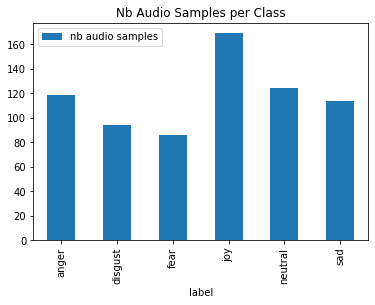

In [9]:
# Number of audio per class
audio_folder = AUDIO_FOLDER
audio_subfolders = [x for x in os.listdir(audio_folder) if os.path.isdir(os.path.join(audio_folder, x))]
audio_subfolders.sort()
n_classes = len(audio_subfolders)
nb_ex_per_class = np.zeros((n_classes), dtype=int)
for c in range(n_classes):
    nb_ex_per_class[c] = len([x for x in os.listdir(os.path.join(audio_folder, audio_subfolders[c]))
                              if x.endswith('.wav')])
print(audio_subfolders)
print(nb_ex_per_class)
# --> 706
df_nb_audio_sample = pd.DataFrame({'label': audio_subfolders, 'nb audio samples': nb_ex_per_class})
df_nb_audio_sample = df_nb_audio_sample.set_index('label')

# Figure
ax = df_nb_audio_sample.plot.bar()
ax.set(title='Nb Audio Samples per Class')

# 2. Show waveform before and after silence removing

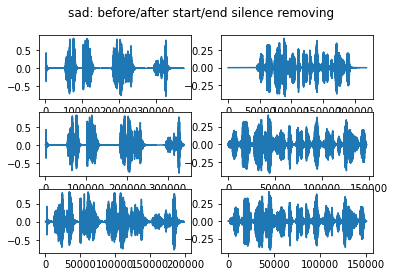

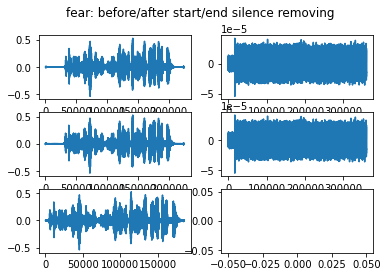

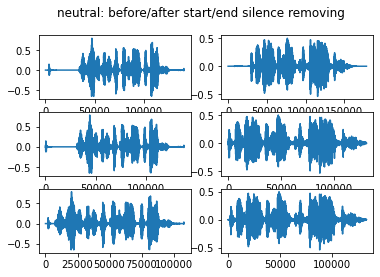

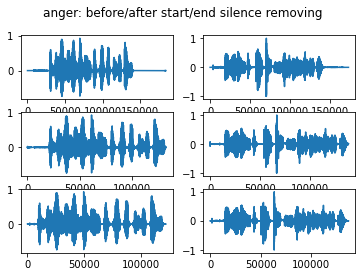

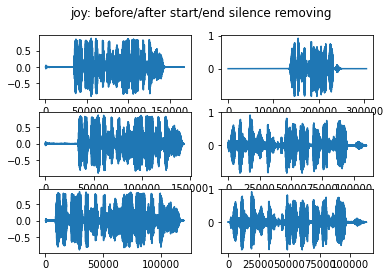

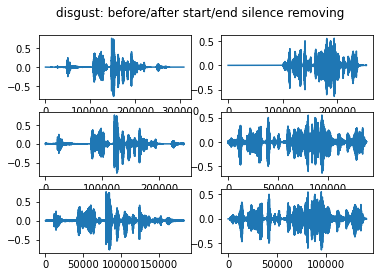

In [12]:
audio_folder = AUDIO_FOLDER
audio_subfolders = [x for x in os.listdir(audio_folder) if os.path.isdir(os.path.join(audio_folder, x))]

n_ex_per_class = 2
for subfolder in audio_subfolders:
    fig = plt.figure()
    plt.suptitle(subfolder+': before/after start/end silence removing')
    list_sound_files = [x for x in os.listdir(os.path.join(audio_folder, subfolder)) if x.endswith('.wav')]
    for index, filename in enumerate(list_sound_files[:n_ex_per_class]):
        sound_path = os.path.join(audio_folder, subfolder, filename)
        waveform, sample_rate = torchaudio.load(sound_path)
        waveform_silence_start_end = remove_silence_start_end(waveform, 0.01)
        waveform_silence_all = remove_silence_intervals(waveform, 0.01, 3600)

        plt.subplot(3,n_ex_per_class, index+1)
        plt.plot(np.squeeze(waveform))
        plt.subplot(3,n_ex_per_class, n_ex_per_class+index+1)
        plt.plot(np.squeeze(waveform_silence_start_end))
        plt.subplot(3,n_ex_per_class, 2*n_ex_per_class+index+1)
        plt.plot(np.squeeze(waveform_silence_all))

# 3. Preprocess audio files: remove silence and save them in another directory

In [27]:
def remove_silence_and_save_preprocessed_files(audio_folder = AUDIO_FOLDER,
                                               dst_audio_folder = AUDIO_FOLDER_preprocessed):
    audio_subfolders = [x for x in os.listdir(audio_folder) if os.path.isdir(os.path.join(audio_folder, x))]

    for subfolder in audio_subfolders:
        os.makedirs(os.path.join(dst_audio_folder, subfolder), exist_ok=True)
        list_sound_files = [x for x in os.listdir(os.path.join(audio_folder, subfolder)) if x.endswith('.wav')]
        for index, filename in enumerate(list_sound_files):
            sound_path = os.path.join(audio_folder, subfolder, filename)
            waveform, sample_rate = torchaudio.load(sound_path)
            waveform_silence_all = remove_silence_intervals(waveform, 0.01, 3600)
            dst_path = os.path.join(dst_audio_folder, subfolder, filename)
            if waveform_silence_all.shape[1]>0:
                amplitude = np.iinfo(np.int16).max
                wavfile.write(dst_path, sample_rate, (amplitude*np.squeeze(np.array(waveform_silence_all))).astype(np.int16))
            else: 
                print('Empty file: %s' %dst_path)

In [30]:
# Uncomment to preprocess audio files: 
#remove_silence_and_save_preprocessed_files(audio_folder = AUDIO_FOLDER, 
#                                         dst_audio_folder = AUDIO_FOLDER_preprocessed)


Empty file: ../data/preprocessed_silence_removed_data/french/sad/sad_4_608f301e-8572-11eb-8203-b216f6aef6a6.wav
Empty file: ../data/preprocessed_silence_removed_data/french/fear/fear_5_abd0fb6a-8ca8-11eb-8203-b216f6aef6a6.wav
Empty file: ../data/preprocessed_silence_removed_data/french/anger/anger_4_947dc0a2-8572-11eb-8203-b216f6aef6a6.wav
Empty file: ../data/preprocessed_silence_removed_data/french/anger/anger_4_7498691e-8ca1-11eb-8203-b216f6aef6a6.wav
Empty file: ../data/preprocessed_silence_removed_data/french/anger/anger_4_7498691e-8ca1-11eb-8203-b216f6aef6a6 17.51.52.wav
Empty file: ../data/preprocessed_silence_removed_data/french/joy/joy_5_0f963842-8c89-11eb-8203-b216f6aef6a6.wav
Empty file: ../data/preprocessed_silence_removed_data/french/joy/joy_4_1c4aecde-856f-11eb-8203-b216f6aef6a6.wav
Empty file: ../data/preprocessed_silence_removed_data/french/joy/joy_7_72800482-8ba9-11eb-8203-b216f6aef6a6.wav
Empty file: ../data/preprocessed_silence_removed_data/french/joy/joy_1_5920b9b0-8

# 4. Audio length distribution

In [34]:
def distribution_length_audio(audio_folder = AUDIO_FOLDER, save_folder = SAVE_FIG_FOLDER,
                              additional_str='_before_silence_removal', save_fig=False):
    audio_subfolders = [x for x in os.listdir(audio_folder) if os.path.isdir(os.path.join(audio_folder, x))]
    audio_subfolders.sort()
    n_classes = len(audio_subfolders)

    # Labels
    list_label = []
    # Audio length
    list_audio_length = []

    for c in range(n_classes):
        list_examples = [x for x in os.listdir(os.path.join(audio_folder, audio_subfolders[c])) if x.endswith('.wav')]
        n_c = len(list_examples)
        for i in range(n_c):
            audio_path = os.path.join(audio_folder, audio_subfolders[c], list_examples[i])
            audio, sampling_rate = torchaudio.load(audio_path)
            # Audio length
            audio_size_in_ms = 1000 * audio.shape[1] / sampling_rate
            list_label.append(c)
            list_audio_length.append(audio_size_in_ms)

    df_audio_length = pd.DataFrame({'label': list_label, 'audio length (ms)': list_audio_length})
    df_audio_length['label'] = df_audio_length['label'].apply(lambda x: audio_subfolders[x])

    # Figure: histogram
    ax_1 = plt.figure()
    sns.histplot(df_audio_length, x='audio length (ms)', hue='label').set(title='Histogram audio length per class')
    if save_fig:
        save_hist_path = os.path.join(save_folder, 'histogram_audio_length'+additional_str+'.jpg')
        ax_1.savefig(save_hist_path)

    # Figure: density distribution
    ax_2 = sns.displot(df_audio_length, x='audio length (ms)', hue='label', kind='kde', fill=True).set(
        title='Distribution audio length per class')
    if save_fig:
        save_dist_path = os.path.join(save_folder, 'distribution_audio_length'+additional_str+'.jpg')
        ax_2.savefig(save_dist_path)

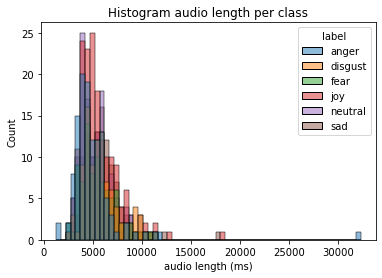

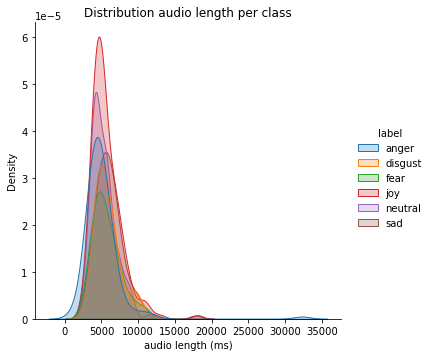

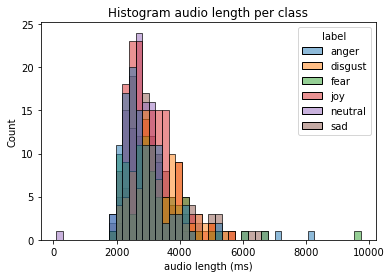

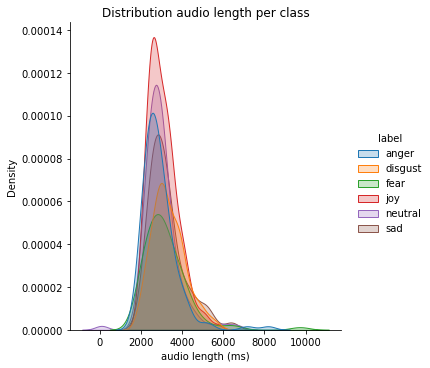

In [35]:
distribution_length_audio(audio_folder = AUDIO_FOLDER, save_folder = SAVE_FIG_FOLDER,
                              additional_str='_before_silence_removal', save_fig = False)
distribution_length_audio(audio_folder = AUDIO_FOLDER_preprocessed, save_folder = SAVE_FIG_FOLDER,
                              additional_str='_after_silence_removal', save_fig = False)

# 5. Amplitude distribution

In [42]:
def distribution_amplitude(audio_folder = AUDIO_FOLDER, save_folder = SAVE_FIG_FOLDER,
                           additional_str='_before_silence_removal', save_fig=False):
    all_subfolders = [x for x in os.listdir(audio_folder) if os.path.isdir(os.path.join(audio_folder, x))]

    bins = np.array([0,1e-5, 1e-4, 1e-3, 1e-2, 0.1,0.5, 1])
    res = np.zeros((bins.shape[0]-1))

    max_value = -np.inf
    min_value = +np.inf
    for label in all_subfolders:
        list_sound_files = [x for x in os.listdir(os.path.join(audio_folder, label)) if x.endswith('.wav')]
        for filename in list_sound_files:
            #print(filename)
            sound_path = os.path.join(audio_folder, label, filename)
            try:
                waveform, sample_rate = torchaudio.load(sound_path)
                #max_value = np.max((max_value, waveform.max()))
                #min_value = np.min((min_value, waveform.min()))
                res_part, _, _ = plt.hist(waveform.abs(), bins=bins)
                res += res_part.astype(int)
            except:
                print('Error with: %s' %filename)

            plt.close()
    #print('Max and min values: %f %f' %(max_value, min_value))

    # Figure
    df = pd.DataFrame({'count':res, 'intervals':bins[1:]})
    plt.figure()
    ax = df.plot.bar(x='intervals',y='count')
    ax.set(title='amplitude histogram')
    if save_fig:
        path_save = os.path.join(save_folder, 'Amplitude Distribution'+additional_str)
        ax.get_figure().savefig(path_save)

<Figure size 432x288 with 0 Axes>

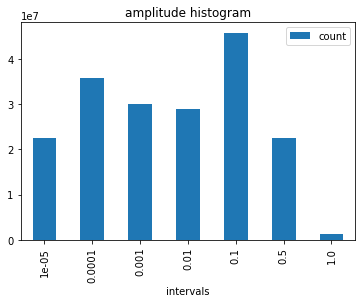

In [43]:
distribution_amplitude(audio_folder = AUDIO_FOLDER,
                       save_folder = SAVE_FIG_FOLDER,
                       additional_str='_before_silence_removal', 
                        save_fig = False)

<Figure size 432x288 with 0 Axes>

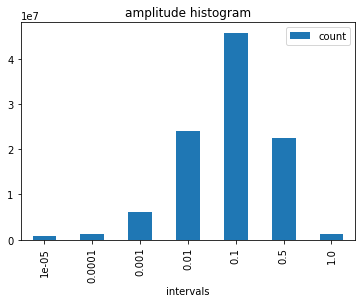

In [44]:
distribution_amplitude(audio_folder=AUDIO_FOLDER_preprocessed,
                       save_folder=SAVE_FIG_FOLDER,
                       additional_str='_after_silence_removal',
                      save_fig = False)

# 6. Proportion of audio file with "silence"

In [45]:
def get_proportion_amplitude_smaller(audio_folder = AUDIO_FOLDER, thresh=0.01):
    all_subfolders = [x for x in os.listdir(audio_folder) if os.path.isdir(os.path.join(audio_folder, x))]
    all_subfolders.sort()

    for label in all_subfolders:
        list_sound_files = [x for x in os.listdir(os.path.join(audio_folder, label)) if x.endswith('.wav')]
        list_proportions = []
        for filename in list_sound_files:
            sound_path = os.path.join(audio_folder, label, filename)
            try:
                waveform, sample_rate = torchaudio.load(sound_path)
                total_size = waveform.shape[1]
                is_silence = waveform.abs()<thresh
                silence_size = is_silence.sum()
                proportion = int(silence_size)/total_size
                list_proportions.append(proportion)
            except:
                print('Error with: %s' %filename)

        print('%s: %f' %(label, np.mean(list_proportions)))

In [47]:
print('------- before silence removal --------')
get_proportion_amplitude_smaller(audio_folder = AUDIO_FOLDER, thresh=0.01)
print('------- after silence removal --------')
get_proportion_amplitude_smaller(audio_folder = AUDIO_FOLDER_preprocessed, thresh=0.01)

------- before silence removal --------
anger: 0.561712
disgust: 0.601751
fear: 0.587000
joy: 0.617175
neutral: 0.605182
sad: 0.643779
------- after silence removal --------
anger: 0.259459
disgust: 0.335522
fear: 0.301805
joy: 0.297605
neutral: 0.342175
sad: 0.355886
